# Multiple Atom Building
The notebook goes through the process to build multi-atom structures, including defining the design, dividing the building process into individual atom manipulation episodes through assignment and path planning algorithms, and running a trained RL agent.

### Importing modules

In [10]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
import torch
from AMRL import show_reset, show_done, show_step, plot_large_frame
from AMRL import Structure_Builder, assignment, Episode_Memory, Createc_Controller, sac_agent
import os
matplotlib.rcParams['image.cmap'] = 'gray'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Define RL_operation function
This function is used to execute atom manipulation with a trained RL agent

In [11]:
def RL_operation(env, agent, atom_chosen, next_destination_nm, anchor_chosen, offset_nm, len_nm, i_episode, max_steps=5):
    """
    Execute atom manipulation with a trained RL agent

    Parameters
    ----------
    env: Structure_Builder
    
    agent: sac_agent
            
    atom_chosen: array_like
            coordinate of the atom to be manipulated
    
    next_destination_nm: array_like
            target position
            
    anchor_chosen: array_like
            anchor atom position
    
    episode_start: int
            Index to use for the starting episode
    
    offset_nm: array_like
            The offset coordinate to use for STM scan
    
    len_nm: float
            The image size to use for STM scan
    
    i_episode: int
            Episode index used for saving data
    
    max_steps: int
            Maximum steps in an episode
            
    Returns
    -------
    env.atom_absolute_nm: array_like
            Atom position
            
    env.dist_destination: array_like
            precision
    
    """
    done = False
    state, done, info = env.reset(next_destination_nm, anchor_chosen, offset_nm, len_nm, large_len_nm)
    show_reset(env.img_info, env.atom_start_absolute_nm, env.destination_absolute_nm)
    episode_memory.update_memory_reset(env.img_info, i_episode, info)
    if done:
        return env.atom_absolute_nm, env.dist_destination
    for step in range(max_steps):
        print('step:', step)
        if np.linalg.norm(env.atom_absolute_nm - atom_chosen)>2:
            print('identify the wrong atom')
            break
        action = agent.select_action(state)
        next_state, reward, done, info = env.step(action)
        mask = float(not done)
        episode_memory.update_memory_step(state, action, next_state, reward, done, info)
        state=next_state
        print('precision:{:3f} nm'.format(env.dist_destination))
        show_step(env.img_info, info['start_nm']+env.atom_absolute_nm, info['end_nm']+env.atom_absolute_nm,env.atom_absolute_nm, 
                  env.atom_start_absolute_nm, env.destination_absolute_nm, 
                  action[4]*env.max_mvolt, action[5]*env.max_pcurrent_to_mvolt_ratio*action[4]*env.max_mvolt)
        if done:
            episode_memory.update_memory_done(env.img_info, env.atom_absolute_nm, np.array([0,0]))
            episode_memory.save_memory(folder_name)
            break
    return env.atom_absolute_nm, env.dist_destination

### Load a trained RL agent and create a Episode_Memory object

In [12]:
#TODO
#Set the folder with saved neural network weights
weight_folder_name = 'C:/LocalUserData/User-data/phys-asp-lab/auto_manipulation/training_Ag_retrain'
episode = 2640 #Set the episode index for the saved neural network weights
agent = sac_agent(num_inputs = 4, num_actions = 6, action_space = None, device=device, hidden_size=256, lr=0.0003,
                 gamma=0.9, tau=0.005, alpha=1)

agent.critic.load_state_dict(torch.load('{}/_critic_{}.pth'.format(weight_folder_name, episode)))
agent.policy.load_state_dict(torch.load('{}/_policy_{}.pth'.format(weight_folder_name, episode)))
agent.alpha = torch.load('{}/_alpha_{}.pth'.format(weight_folder_name, episode))

episode_memory = Episode_Memory()

FileNotFoundError: [Errno 2] No such file or directory: 'C:/LocalUserData/User-data/phys-asp-lab/auto_manipulation/training_Ag_retrain/_critic_2640.pth'

### Define the design in a numpy array

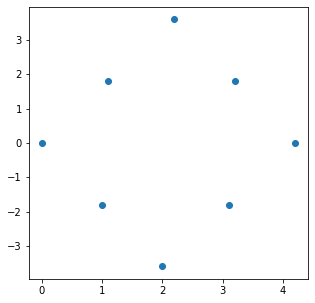

In [4]:
design_nm = np.array([[ 0. ,  0. ],[ 1.1,  1.8],
                   [ 2.2,  3.6],[ 3.2,  1.8],
                   [ 3.1, -1.8],[ 4.2,  0. ],
                   [ 2. , -3.6],[ 1. , -1.8]])#,
plt.subplots(figsize=(5,5))
plt.scatter(design_nm[:,0], design_nm[:,1])

### Define obstacle coordinate
Define atoms that might appear in the scanning frame, but will not be manipulated. Use the coordinate of the design. Set as None if there is not.  

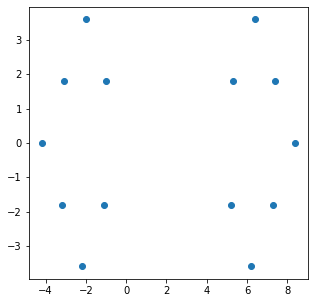

In [5]:
design_nm_left = np.array([[ 0. ,  0. ],[ 1.1,  1.8],
                   [ 2.2,  3.6],[ 3.2,  1.8],
                   [ 3.1, -1.8],
                   [ 2. , -3.6],[ 1. , -1.8]])

design_nm_right = np.array([[ 1.1,  1.8],
                   [ 2.2,  3.6],[ 3.2,  1.8],
                   [ 3.1, -1.8],[ 4.2,  0. ],
                   [ 2. , -3.6],[ 1. , -1.8]])
#TODO
#Set obstacles coordinate values
obstacles = np.concatenate((design_nm_left-np.array([4.2,0]),design_nm_right+np.array([4.2,0])))
outside_obstacles = np.ones((obstacles.shape[0],3))
outside_obstacles[:,:2] = obstacles
plt.subplots(figsize=(5,5))
plt.scatter(obstacles[:,0], obstacles[:,1])

### Set the parameters and create a Structure_Builder object

In [13]:
#Set STM scan parameters
pixel = 128 
large_len_nm = 9.033 #Image size in nm 
scan_mV = 500 #bias voltage
speed = 1200 #scan speed (A/s)
createc_controller = Createc_Controller(None, None, None, None)
x_nm, y_nm = createc_controller.get_offset_nm()
large_offset_nm = np.array([x_nm, y_nm]) #Set offset to current offset value


step_nm = 0.4 #Set the radius of the manipulation start position relative the the atom start position
goal_nm  = 2 #Set the radius of the manipulation end position relative the the atom start position
max_mvolt = 15 #Set the maximum bias voltage in mV 
max_pcurrent_to_mvolt_ratio = 6E3 #Set the maximum conductance in pA/mV
max_len = 5 #Set maximum episode length
#Set the path to load CNN weight for the atom movement classifier
current_jump  = 4 #Set the current jump gradient/ std(current) threshold required to take STM scan

precision_lim = 0.288/np.sqrt(3) #Set the target precision for each atom manipulation episode
safe_radius_nm = 1 #Set the safe distance between two atoms

env = Structure_Builder(step_nm, max_mvolt, max_pcurrent_to_mvolt_ratio, goal_nm,
                        current_jump, large_len_nm, large_offset_nm, pixel, scan_mV, max_len,
                        speed = speed, precision_lim = precision_lim, safe_radius_nm = safe_radius_nm)

NameError: name 'win32com' is not defined

### Define folder name for saving data

In [14]:
folder_name = 'C:/LocalUserData/User-data/phys-asp-lab/auto_manipulation/kagome_build_1/diamond_15'

if not os.path.exists(folder_name):
  # Create a new directory because it does not exist 
  os.makedirs(folder_name)
  print("The new directory is created!")

The new directory is created!


### Set the parameters and start the building process

In [15]:
#TODO
#If align_design_mode = 'manual', one atom in the design is aligned with one atom in the STM image
#We need to define anchor_position, anchor_design, and outside_obstacles.

#If align_design_mode = 'auto', the structure is built wherever the total manipulation distance is minimized

anchor_position = np.array([-201,-80.7])
anchor_design = np.array([ 2.2,  3.6])
returns = env.reset_large(design_nm,
                  align_design_mode = 'manual',
                  align_design_params = {'atom_nm':anchor_position, 'design_nm':anchor_design, 'obstacle_nm':outside_obstacles},
                  sequence_mode = 'design')

atom_chosen, design_chosen, next_destination_nm, path, anchor_chosen, offset_nm, len_nm = returns
np.save(folder_name+'/{}_episode_img_info.npy'.format(-1),env.large_img_info)

max_episodes = 30
for i in range(max_episodes):
    print('STEP:', i)
    plot_large_frame(env.large_img_info, atom_chosen, design_chosen, anchor_chosen, next_destination_nm, path)
    new_atom_position, dist_destination = RL_operation(env, agent, atom_chosen, next_destination_nm, anchor_chosen, offset_nm, len_nm, i)
    succeed = dist_destination<env.precision_lim
    atom_chosen, design_chosen, next_destination_nm, path, anchor_chosen, offset_nm, len_nm, done = env.step_large(succeed, new_atom_position)
    if succeed:
        print('Episode success, designs remain:', env.designs.shape[0], 'atoms remain:',env.atoms.shape[0])
        done = (env.designs.shape[0] == 0) and (env.atoms.shape[0]==0)
    np.save(folder_name+'/{}_episode_img_info.npy'.format(i), env.large_img_info)
    if done:
        break

NameError: name 'env' is not defined